# 风格转换

感谢大家来我的网站学习https://www.captainbed.net

本次实战编程带领大家实现一个神经风格转换程序。

神经风格转换是深度学习领域中一个很有趣的技术。它可以改变图像的风格。如下图所示，根据一张内容图片和一张风格图片，生成一张新图片，这张图片结合了第一张图像的内容和第二张图像的风格。
<img src="images/louvre_generated.png" style="width:750px;height:200px;">

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
# 工具函数，从给定地址加载图片
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [3]:
# 工具函数，将图片显示出来
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

本次我们使用google网站上的两张图片来演示风格转换。下面的content_path表示内容图片的地址，style_path指风格图片的地址。
由于后面不少代码都要联网，所以有时候代码执行会花一些时间，并且有时候因为网络问题会导致执行失败，多试几次就能成功的！！

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

下面的代码会将内容图片和风格图片加载进来并且显示出来。

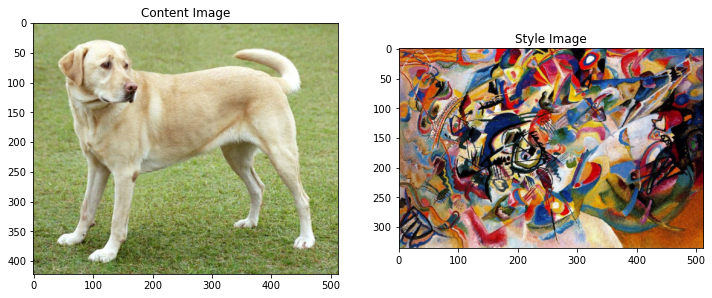

In [5]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

其实在tensorflow hub中已经有现成的风格转换模型可以被免费调用了。除了风格转换模型外，hub中还包含了很多常见的模型，很强大很可怕！！大家可以自己去看看https://hub.tensorflow.google.cn/

下面我就给大家展示一下如何调用hub中的模型来实现风格转换。

In [6]:
# 一个工具函数，将tensor转换为图片。并且显示出来
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

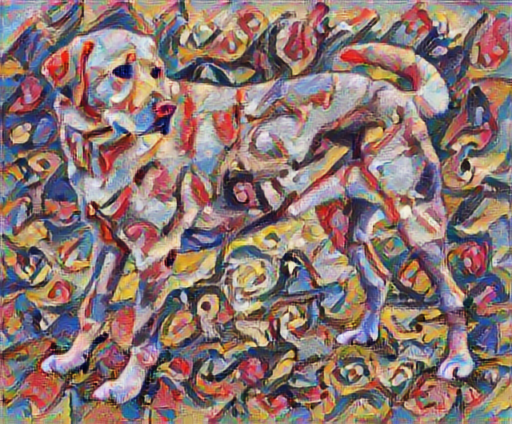

In [7]:
# 需要先安装pip install tensorflow-hub-0.12.0
import tensorflow_hub as hub
hub_model = hub.load('https://hub.tensorflow.google.cn/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

是不是很可怕。简单的几行代码就实现了风格转换！

当然，咱们的目的是教学，所以下面依然会带领大家“手动”实现风格转换，这样大家才能更加深刻地明白风格转换的原理。

之前我们已经学习过了迁移学习。迁移学习其实就是利用已经训练好的模型来实现另一个任务。神经风格转换Neural Style Transfer (NST)也利用了迁移学习，以及之前超火的AI换脸也可以使用迁移学习来实现。本次编程中，我们使用的是已经训练好了的VGG-19模型。这个模型已经在巨大的数据库上训练过了，它前面的神经网络层已经学会了识别很多低层次特性，后面的神经网络层则能识别很多高级复杂的特性。

下面的代码创建了一个VGG19模型，并且将在imagenet上训练好了的参数值赋给它。

In [8]:
# vgg就代表了一个训练好了的VGG19模型
# include_top=False代表不需要最后一层。因为咱们只用它来风格转换，不需要最后一层，最后一层是用来识别图片的。
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# 将每层的名字打印出来
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


通过前面的学习我们已经知道，前面的神经网络层会学会识别低层次的特性，例如边缘和纹理等，而后面的网络层会学会高级复杂的特性，例如人脸和车。

风格转换产生的图片既要有内容图片的内容又要有风格图片的风格。下面我们将使用内容图片的VGG的block5_conv2层来生成最终图像的内容，同时用风格图片的VGG的block1_conv1，block2_conv1，block3_conv1，block4_conv1，block5_conv1来生成最终图片的风格。

In [9]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [10]:
# 创建一个自定义的模型
# 在输入vgg.input后（也就是一张图片后），这个函数会返回上面定义的那些网络层的激活值。
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

通过上面的函数我们就能获取代表内容和风格的网络层的激活值了。但是呢，我们不能直接通过激活值来比对风格，我们需要先将激活值矩阵转换成风格矩阵，然后才能通过对比风格矩阵来判断两张图片的风格是否相同。下面的函数会将激活值矩阵转换成风格矩阵。

In [11]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

下面我们用subclassing的方式定义了一个类。

这个类整合了上面那些工具函数。

当将一张图片输入后，这个类会返回这个图片的内容激活值矩阵以及风格矩阵。

In [12]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False 

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [13]:
extractor = StyleContentModel(style_layers, content_layers)

In [14]:
style_targets = extractor(style_image)['style'] # 获取风格图片的风格矩阵
content_targets = extractor(content_image)['content'] # 获取内容图片的内容激活值矩阵

In [15]:
# 复制内容图片到image。
# 后面会不断的根据content_image和style_image来改变image，时image的风格越来越像style_image
image = tf.Variable(content_image)

In [16]:
# 一个工具函数，用来修剪图片的数值
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [17]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [18]:
style_weight=1e-2 # 可以通过这个值来控制风格化到什么程度
content_weight=1e4 # 控制内容保留的程度

In [19]:
# 用这个函数来对比最终图片image与内容图片content_image风格图片style_image的差别。
# 也就是我们所说的损失函数。差别越大损失就越大。
# 当iamge的内容越来越像content_image，风格越来越像style_image，那么损失就会越来越小。
def style_content_loss(outputs):
    style_outputs = outputs['style'] # image当前的风格矩阵
    content_outputs = outputs['content'] # image当前的内容激活值矩阵
    
    # 计算风格损失
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # 计算内容损失
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss
    return loss

下面的函数定义了一步完整的训练

In [20]:
@tf.function()
def train_step(image):
  # tape会记录下前向传播的每一个步骤，后面好自动执行反向传播
  with tf.GradientTape() as tape:
    outputs = extractor(image) # 获取当前image的内容激活值矩阵和风格矩阵
    loss = style_content_loss(outputs) # 计算损失。即与内容图片content_image风格图片style_image的差距

  # 获取image相对于loss的梯度。这里的image就相当于w和b参数一样。
  grad = tape.gradient(loss, image)
  # 使用梯度来改变image，也即是说image会变得越来越像content_image风格图片style_image
  opt.apply_gradients([(grad, image)]) 
  
  image.assign(clip_0_1(image))

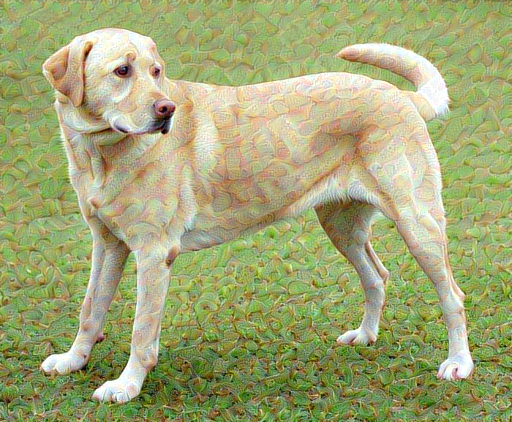

In [21]:
# 下面我们只训练3步。从结果可以看出，图片已经有了一点点风格图片的感觉了
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

下面的代码就是训练很多步。注意哦，会花很长时间，电脑配置不好的可能要花几个小时，甚至更长。

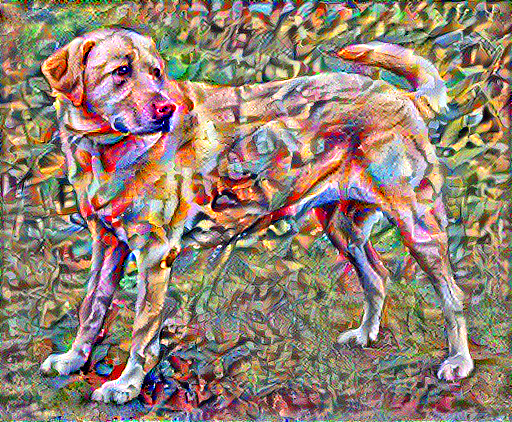

Train step: 400
...........

In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))